In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import Planck18 as cosmos
h = cosmos.H0.value/100
from astropy.io import fits
import healpy as hp
import seaborn as sns
from imsys_fitter import Syst

In [2]:
# data = fits.getdata('/uufs/chpc.utah.edu/common/home/astro/zheng/hd/data/SDSS_eBOSS_weight_maps/SDSS_WISE_imageprop_nside512.fits')
data = fits.getdata('/uufs/chpc.utah.edu/common/home/astro/zheng/hd/data/SDSS_eBOSS_weight_maps/SDSSimageprop_Nside512.fits')

In [3]:
random_n = fits.getdata('/uufs/chpc.utah.edu/common/home/astro/zheng/hd/data/SDSS16Q/eBOSS_QSO_clustering_random-NGC-vDR16.fits')
random_s = fits.getdata('/uufs/chpc.utah.edu/common/home/astro/zheng/hd/data/SDSS16Q/eBOSS_QSO_clustering_random-SGC-vDR16.fits')
random_all = np.hstack((random_n, random_s))

In [4]:
quasar_n = fits.getdata('/uufs/chpc.utah.edu/common/home/astro/zheng/hd/data/SDSS16Q/eBOSS_QSO_clustering_data-NGC-vDR16.fits')
quasar_s = fits.getdata('/uufs/chpc.utah.edu/common/home/astro/zheng/hd/data/SDSS16Q/eBOSS_QSO_clustering_data-SGC-vDR16.fits')
quasar_all = np.hstack((quasar_n, quasar_s))

In [5]:
Nside = 512
Npix = hp.nside2npix(Nside)
print(f'scale: {hp.nside2resol(Nside, True)} arcmin')

scale: 6.870972823634812 arcmin


In [6]:
quasar_cata = quasar_n
random_cata = random_n

In [7]:
pix = hp.ang2pix(Nside, np.deg2rad(90 - quasar_cata['DEC']), np.deg2rad(quasar_cata['RA']))
pix_r = hp.ang2pix(Nside, np.deg2rad(90 - random_cata['DEC']), np.deg2rad(random_cata['RA']))

In [9]:
Rg = 3.793                                      # from 2002AJ....123..485S table 22
# Rg = 3.303
data_q = {}
data_r = {}

data_q['EBV'] = data['EBV'][pix]
data_q['DEPTH_G'] = 22.5 - 2.5*np.log10(data['DEPTH_G'][pix]) - Rg*data_q['EBV']
data_q['SKY_I'] = data['SKY_I'][pix]
data_q['PSF_I'] = data['PSF_I'][pix]

data_r['EBV'] = data['EBV'][pix_r]
data_r['DEPTH_G'] = 22.5 - 2.5*np.log10(data['DEPTH_G'][pix_r]) - Rg*data_r['EBV']
data_r['SKY_I'] = data['SKY_I'][pix_r]
data_r['PSF_I'] = data['PSF_I'][pix_r]

In [10]:
analyzer = Syst(quasar_cata['WEIGHT_FKP']*quasar_cata['WEIGHT_CP']*quasar_cata['WEIGHT_NOZ'], random_cata['WEIGHT_FKP'])
# analyzer = Syst(np.ones_like(quasar_cata['WEIGHT_FKP']), np.ones_like(random_cata['WEIGHT_FKP']))

In [11]:
for k in data_q.keys():
    analyzer.add_syst(k, data_q[k], data_r[k])
analyzer.cut_outliers(p=1)
analyzer.prepare()
analyzer.fit_minuit()

(0.0, 0, 0, 0, 0)
Maps available for chi2:
['EBV', 'DEPTH_G', 'SKY_I', 'PSF_I']
Fitting for:
['constant', 'EBV', 'DEPTH_G', 'SKY_I', 'PSF_I']
chi2 (before fit) = 646.54   ndata = 40                rchi2 = 16.1634
chi2 (after  fit) = 73.86   ndata = 40   npars = 5   rchi2 = 2.1104


In [12]:
result = dict(zip(analyzer.par_names, analyzer.best_pars))

In [13]:
weight_model = 1/analyzer.get_model(result, analyzer.data_syst)

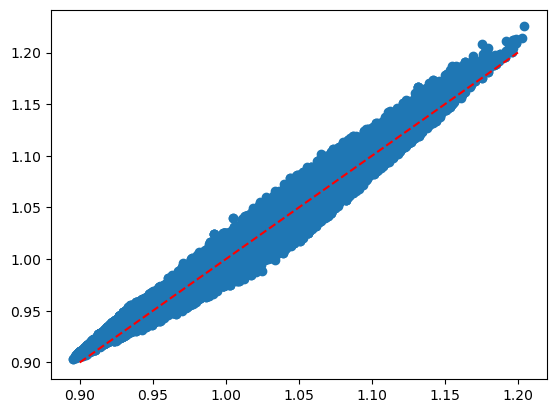

In [14]:
plt.scatter(quasar_cata['WEIGHT_SYSTOT'][analyzer.w_data], weight_model)
plt.plot([0.9, 1.2], [0.9, 1.2], 'r--')

In [15]:
pix = hp.ang2pix(Nside, np.deg2rad(90 - quasar_cata['dec']), np.deg2rad(quasar_cata['ra']))

pix_r = hp.ang2pix(Nside, np.deg2rad(90 - random_cata['DEC']), np.deg2rad(random_cata['RA']))
pix_ur = np.unique(pix_r)
count = np.bincount(pix, minlength=Npix, weights=quasar_cata['WEIGHT_FKP']*quasar_cata['WEIGHT_CP']*quasar_cata['WEIGHT_NOZ'])                                            # number count in each area

Nbins = 10
bin_edge = np.linspace(0, 0.15, Nbins+1, True)
bin_center = (bin_edge[1:] + bin_edge[:-1])/2
Rg = 3.793                                      # from 2002AJ....123..485S table 22
ebv_q = data['EBV'][pix]
depth_g_q = 22.5 - 2.5*np.log10(data['DEPTH_G'][pix]) - Rg*ebv_q
sky_i_q = data['SKY_I'][pix]
psf_i_q = data['PSF_I'][pix]
# random pixels
count_all = count[pix_ur]
Ebv = data['EBV'][pix_ur]
depth_g = data['DEPTH_G'][pix_ur]
sky_i = data['SKY_I'][pix_ur]
psf_i = data['PSF_I'][pix_ur]

properties = {
    'EBV': Ebv,
    'DEPTH_G': 22.5 - 2.5*np.log10(depth_g) - Ebv*Rg,
    'SKY_I': sky_i,
    'PSF_I': psf_i
}

valid = np.ones(len(count_all), bool)
for p in properties.values():
    valid &= ~np.isnan(p)
# cut outliers
outliers = np.zeros(len(count_all), bool)
for feature in properties.values():
    _min, _max = np.percentile(feature[valid], [0.5, 99.5])
    outliers |= ((feature < _min) | (feature > _max))

valid &= ~outliers

count_all = count_all[valid]
for k, v in properties.items():
    properties[k] = v[valid]

density = count_all / count_all.mean()
y = {}
y_err = {}
x = {}
edge = {}
for name, feature in properties.items():
    Nbins = 10
    bin_edge = np.linspace(feature.min(), feature.max(), Nbins+1, True)
    bin_center = (bin_edge[1:] + bin_edge[:-1])/2
    dig_res = np.digitize(feature, bin_edge)
    res = []
    err = []
    for i in range(1, Nbins+1):
        sub_sample = density[dig_res == i]
        mean = sub_sample.mean()
        N = len(sub_sample)
        res.append(mean)
        err.append(np.sqrt(mean / N))
    y[name] = np.array(res)
    y_err[name] = np.array(err)
    x[name] = np.array(bin_center)
    edge[name] = bin_edge

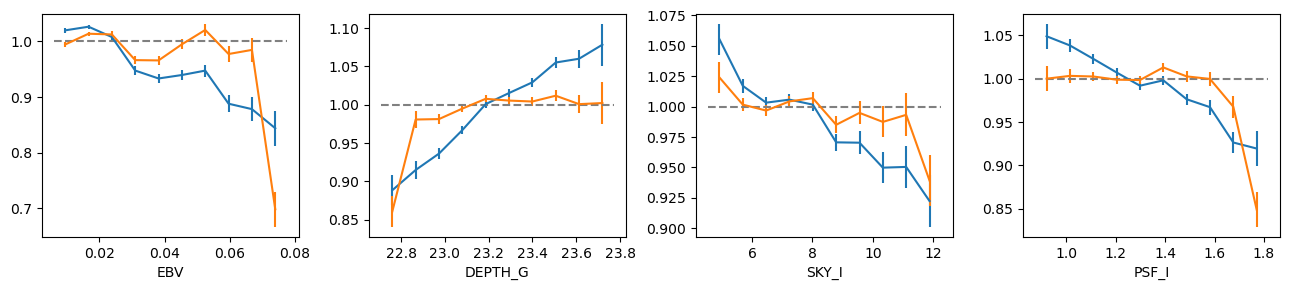

In [18]:
digitize_dict = {}
for name, feature in properties.items():
    Nbins = 10
    bin_edge = np.linspace(feature.min(), feature.max(), Nbins+1, True)
    digitize_dict[name] = np.digitize(feature, bin_edge)


count = np.bincount(pix[analyzer.w_data], minlength=Npix, weights=weight_model)
count = count[pix_ur][valid]
density_w = count/count.mean()
y_w = {}
y_w_err = {}
for name, feature in properties.items():
    dig_res = digitize_dict[name]
    res = []
    err = []
    for i in range(1, Nbins+1):
        sub_sample = density_w[dig_res == i]
        mean = sub_sample.mean()
        N = len(sub_sample)
        res.append(mean)
        err.append(np.sqrt(mean/N))
    y_w[name] = np.array(res)
    y_w_err[name] = np.array(err)
fig, ax = plt.subplots(1, 4, figsize=(13, 3))
for i, name in enumerate(properties.keys()):
    ax[i].errorbar(x[name], y[name], y_err[name])
    ax[i].errorbar(x[name], y_w[name], y_err[name])
    ax[i].set_xlabel(name)
    ax[i].hlines(1, edge[name][0], edge[name][-1], linestyle='--', color='gray')
plt.tight_layout()

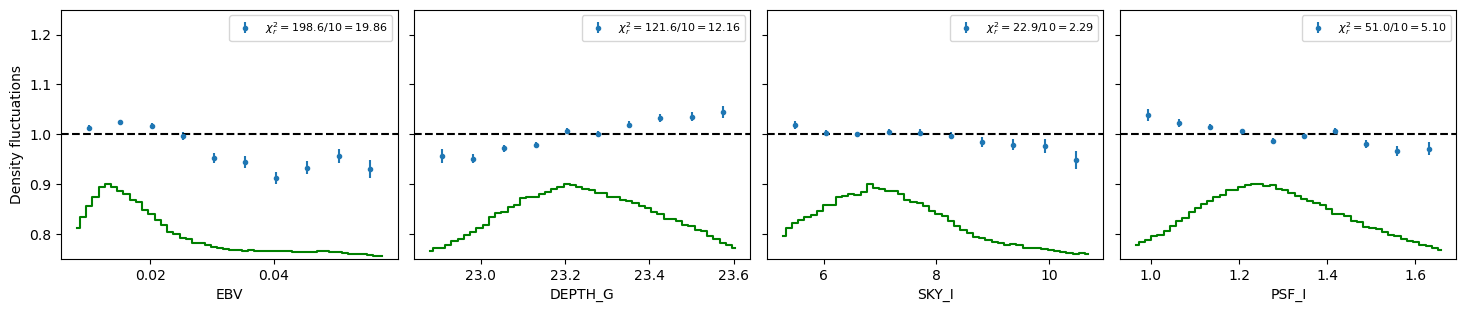

In [75]:
analyzer.plot_overdensity()